<a href="https://colab.research.google.com/github/linbeta/ingredients_recognition_model/blob/main/1223_65_MobileNetV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 載入dataset: 28個類別
# https://drive.google.com/file/d/1QoMGw4CHu2vosENn2EffY_ilzKKkAhGm/view?usp=sharing
# !gdown --id '1QoMGw4CHu2vosENn2EffY_ilzKKkAhGm' -O dataset.zip
# 載入dataset: 65個類別
!gdown --id '1aEs1LlGHttR8Ur9dpe6dpv-nJ5Bz1p_8' -O dataset.zip
!unzip dataset.zip

串流輸出內容已截斷至最後 5000 行。
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_18.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_19.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_2.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_20.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_21.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_22.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_23.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_24.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_25.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_26.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_27.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_28.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_29.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_3.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_30.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_31.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_32.jpg  
  inflating: 1222_Aug_65/60_Kiwi_aug/60_Kiwi_33.jpg  
  inflati

In [ ]:
# 載入類別對照表(共71類)
# https://drive.google.com/file/d/13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK/view?usp=sharing
!gdown --id '13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK'

Downloading...
From: https://drive.google.com/uc?id=13bL3CO52WM70pqIpWI4LXJ2T2kiL1BFK
To: /content/71_classes_labels.txt
100% 878/878 [00:00<00:00, 769kB/s]


In [ ]:
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import tensorflow as tf
import cv2
import numpy as np
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image as im
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import plot_model
import imgaug as ia
from imgaug import augmenters as iaa

In [ ]:
# 從類別編號對照表中讀取類別數字對應的類別名稱
class_dict = {}
with open('./71_classes_labels.txt', "r", encoding='utf-8') as f:
  for line in f:
    (key, value) = line.split()
    class_dict[key.zfill(2)] = value
print(class_dict)
# 這包共有28個訓練類別
class_list = []
folder_paths = glob('/content/1222_Aug_65/*')
for path in folder_paths:
  label = path.split('/')[-1].split('_')[0]
  if label != "labels.txt":
    class_list.append(label)

# 把class_list依照大小排序(這樣比較好看XD)
class_list.sort()
print(class_list)
print(len(class_list))

{'00': '空心菜', '01': '小白菜', '02': '青江菜', '03': '豆芽菜', '04': '地瓜葉', '05': '花椰菜', '06': '芥藍菜', '07': '大白菜', '08': '高麗菜', '09': '長年菜', '10': '金針菇', '11': '杏鮑菇', '12': '香菇', '13': '乾香菇', '14': '綜合菇類', '15': '豬五花', '16': '豬肉片', '17': '豬絞肉', '18': '牛肉', '19': '羊肉', '20': '奶油', '21': '雞肉', '22': '魚肉', '23': '雞胸肉', '24': '鮭魚', '25': '紅蘿蔔', '26': '白蘿蔔', '27': '馬鈴薯', '28': '地瓜', '29': '青椒', '30': '甜椒', '31': '雞蛋', '32': '番茄', '33': '蝦子', '34': '洋蔥', '35': '辣椒', '36': '蘋果', '37': '九層塔', '38': '八角', '39': '秋葵', '40': '蔥', '41': '薑', '42': '蒜頭', '43': '猴頭菇', '44': '玉米', '45': '豆腐', '46': '板豆腐', '47': '豆干', '48': '鳳梨', '49': '韭菜', '50': '這不是食材', '51': '蛤蠣', '52': '小黃瓜', '53': '胡瓜', '54': '櫛瓜', '55': '茄子', '56': '絲瓜', '57': '南瓜', '58': '橘子', '59': '香蕉', '60': '奇異果', '61': '白飯', '62': '雞翅', '63': '雞腿', '64': '苦瓜', '65': '福山萵苣_又名大陸妹', '66': '皮蛋', '67': '豆皮', '68': '木耳', '69': '茼蒿', '70': '小松菜'}
['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '

In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
  def __init__(self, img_paths, batch_size, img_size, shuffle=True, aug=False):
    self.img_paths = img_paths
    self.batch_size = batch_size
    self.img_size = img_size
    self.shuffle = shuffle
    self.aug = aug

    self.indexes = np.arange(len(self.img_paths)) # [0, 1, 2, 3, 4, 5, 6, ~]
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.img_paths) / self.batch_size)) # batches per epoch

  def __getitem__(self, batch_index):
    # Generate indexes of the batch
    idxs = self.indexes[batch_index * self.batch_size: (batch_index + 1) * self.batch_size]
    # Find list of IDs
    batch_img_paths = [self.img_paths[i] for i in idxs]

    # Generates data containing batch_size samples
    x = np.empty((len(batch_img_paths), self.img_size, self.img_size, 3), dtype=np.float32)
    y = np.empty((len(batch_img_paths), 1), dtype=np.float32)

    for i, img_path in enumerate(batch_img_paths):
      label = img_path.split('/')[-2].split('_')[0]
      # read img and handle preprocess_input
      if label == "99":
        # 讀99號資料夾裡面的照片和csv檔

        x[i] = img
        y[i] = cls
      else:
        img = im.load_img(img_path).resize((self.img_size, self.img_size))
        img = im.img_to_array(img)

        if self.aug:
          img = self.augmentor(img)
    
        img_p = preprocess_input(img)
        # read class label: 讀取訓練資料的資料夾名稱的類別數字
        # 從自訂的class_list轉換到65個類別的序號cls
        cls = class_list.index(label)

        x[i] = img_p
        y[i] = cls
      

    # one-hot encoding
    y = tf.keras.utils.to_categorical(y, 65)
    
    return x, y

  def on_epoch_end(self):
    # Updates indexes after each epoch
    if self.shuffle:
      np.random.shuffle(self.indexes)

  def augmentor(self, image):
    seq = iaa.Sequential([
      iaa.Flipud(0.5),  # vertically flip 20% of all images
      iaa.Fliplr(0.5),  # 镜像
      iaa.Multiply((1.2, 1.5)),  # change brightness, doesn't affect BBs
      iaa.GaussianBlur(sigma=(0, 3.0)),  # iaa.GaussianBlur(0.5),
      iaa.Affine(
          translate_px={"x": 15, "y": 15},
          scale=(0.8, 0.95),
          rotate=(-30, 30)
      )  # translate by 40/60px on x/y axis, and scale to 50-70%, affects BBs
    ])
    return seq.augment_image(image)


39706

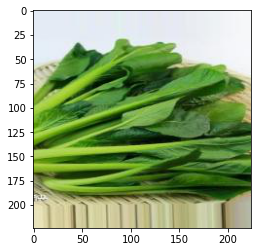

In [ ]:
img_paths = glob('/content/1222_Aug_65/*/*.jpg')
plt.imshow(Image.open(img_paths[12345]))
len(img_paths)

In [ ]:
train_img_paths, val_img_paths = train_test_split(img_paths, test_size=0.2)
len(train_img_paths), len(val_img_paths)

(31764, 7942)

In [ ]:
# train_gen_1 = DataGenerator(train_img_paths, 32, 224, shuffle=True, aug=False)
train_gen_2 = DataGenerator(train_img_paths, 32, 224, shuffle=True, aug=False)
val_gen = DataGenerator(val_img_paths, 32, 224, shuffle=False, aug=False)


In [ ]:
x, y = train_gen_2[0]
# y的答案是根據class_list生成的編碼排序再轉換為0~27的數字編碼，預測的轉換需要再用class_list轉回label編碼
print(y)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
from tensorflow.python.keras.applications import mobilenet_v2
# 用DenseNet169的CNN層接到65個分類的分類器用sigmoid activation function來做MLP分類層
con = MobileNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

for layer in cnn.layers:
  layer.trainable = False

# MLP
x = con.output
x = BatchNormalization()(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(128, activation='relu')(x)
output = Dense(65, activation='sigmoid')(x)

model = Model(cnn.input, output)
model.summary()


9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

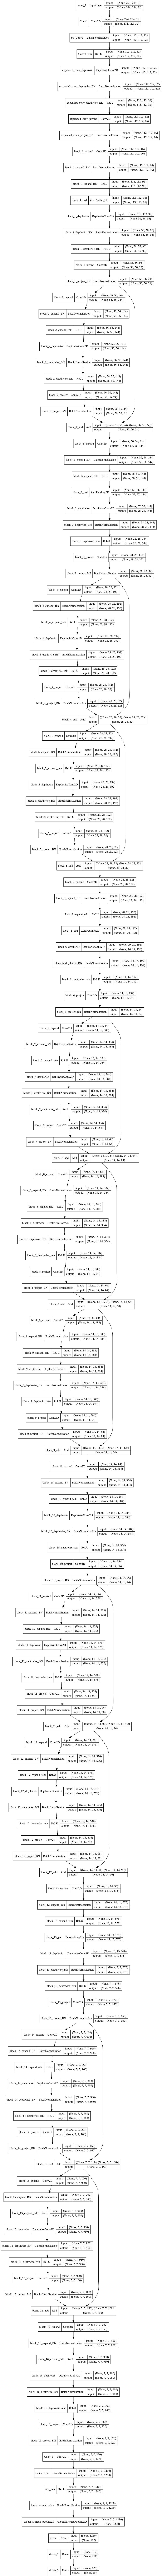

In [ ]:
# 畫出model的圖
# plot_model(model, to_file="/content/drive/MyDrive/Models/1220_DN121_model.png", show_shapes=True)
plot_model(model, to_file="/content/drive/MyDrive/Models/1223_MobileNetv2_model.png", show_shapes=True)

In [ ]:
# !pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 6.8 MB/s 


In [ ]:
# 一個輸出(二元分類): BinaryCrossEntropy p log 1/q + (1 - p) log 1/1-q
# 多個輸出(多元分類): CategoricalCrossEntropy pi log1/qi
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
# import tensorflow_addons as tfa
# model.compile(loss=SparseCategoricalCrossentropy(),
#               optimizer="adam",
#               metrics=["accuracy"])

model.compile(loss=BinaryCrossentropy(),
      optimizer="adam",
      metrics=["accuracy"])

# 另一個方法
# fl = tfa.losses.SigmoidFocalCrossEntropy()
# model.compile(loss=fl,
#       optimizer="adam",
#       metrics=["accuracy"])

In [ ]:
# 開始訓練，把訓練結果存在logs裡面，可以查看詳細資訊
logs = model.fit(train_gen_2, validation_data=val_gen, epochs=10)
# history = logs.history
# model.save('/content/drive/MyDrive/Models/1223_65_DN169_model.h5')
# model.save_weights('/content/drive/MyDrive/Models/1223_65_DN169_model_weight.h5')

Epoch 1/10
993/993 [==============================] - 99s 88ms/step - loss: 0.0271 - accuracy: 0.7644 - val_loss: 0.0110 - val_accuracy: 0.8902
Epoch 2/10
993/993 [==============================] - 76s 76ms/step - loss: 0.0077 - accuracy: 0.9364 - val_loss: 0.0074 - val_accuracy: 0.9362
Epoch 3/10
993/993 [==============================] - 75s 76ms/step - loss: 0.0040 - accuracy: 0.9748 - val_loss: 0.0066 - val_accuracy: 0.9461
Epoch 4/10
993/993 [==============================] - 81s 82ms/step - loss: 0.0027 - accuracy: 0.9853 - val_loss: 0.0058 - val_accuracy: 0.9538
Epoch 5/10
993/993 [==============================] - 75s 76ms/step - loss: 0.0020 - accuracy: 0.9911 - val_loss: 0.0066 - val_accuracy: 0.9494
Epoch 6/10
993/993 [==============================] - 76s 76ms/step - loss: 0.0018 - accuracy: 0.9911 - val_loss: 0.0059 - val_accuracy: 0.9572
Epoch 7/10
993/993 [==============================] - 76s 76ms/step - loss: 0.0015 - accuracy: 0.9933 - val_loss: 0.0060 - val_accuracy:

In [ ]:
history = logs.history

In [ ]:
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  3
val loss  0.0058405110612511635
val acc 0.9537899494171143


Text(0.5, 1.0, 'loss')

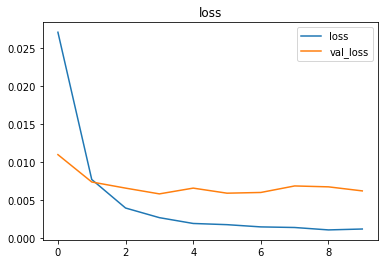

In [ ]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

In [ ]:
model.save('/content/drive/MyDrive/Models/1223_MNv2_model.h5')
model.save_weights('/content/drive/MyDrive/Models/1223_MNv2_weight.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [ ]:
# https://drive.google.com/file/d/1kUP6Qe6AgEXLrA7OvNrxlZhXrfqNft6u/view?usp=sharing
!gdown --id '1kUP6Qe6AgEXLrA7OvNrxlZhXrfqNft6u' -O val_img_square.zip
!unzip val_img_square.zip

Downloading...
From: https://drive.google.com/uc?id=1kUP6Qe6AgEXLrA7OvNrxlZhXrfqNft6u
To: /content/val_img_square.zip
100% 3.57M/3.57M [00:00<00:00, 115MB/s]
Archive:  val_img_square.zip
  inflating: val_img/val_img_1.jpg   
  inflating: val_img/val_img_10.jpg  
  inflating: val_img/val_img_100.jpg  
  inflating: val_img/val_img_101.jpg  
  inflating: val_img/val_img_102.jpg  
  inflating: val_img/val_img_103.jpg  
  inflating: val_img/val_img_104.jpg  
  inflating: val_img/val_img_105.jpg  
  inflating: val_img/val_img_106.jpg  
  inflating: val_img/val_img_107.jpg  
  inflating: val_img/val_img_108.jpg  
  inflating: val_img/val_img_109.jpg  
  inflating: val_img/val_img_11.jpg  
  inflating: val_img/val_img_110.jpg  
  inflating: val_img/val_img_111.jpg  
  inflating: val_img/val_img_112.jpg  
  inflating: val_img/val_img_12.jpg  
  inflating: val_img/val_img_13.jpg  
  inflating: val_img/val_img_14.jpg  
  inflating: val_img/val_img_15.jpg  
  inflating: val_img/val_img_16.jpg  
  

In [ ]:
"""
切圖：對預測圖片進行預處理的函式
"""

# 將圖片填成正方形
def fill_image(image):
    width, height = image.size
    # 長寬取大的值作為邊長
    new_image_length = width if width > height else height
    # 做一張白色的新圖片
    new_image = Image.new(image.mode, (new_image_length, new_image_length), color='white')
    # 將圖片貼在新圖上，(x,y)表示黏貼原圖相對白底的起始位置
    if width > height:
        new_image.paste(image, (0, int((new_image_length - height) / 2)))
    else:
        new_image.paste(image, (int((new_image_length - width) / 2),0))
    return new_image

# 切圖
def cut_image(image, num=3):
    width, height = image.size
    item_width = int(width / num)
    box_list = []
    # (left, upper, right, lower)
    for i in range(0, num):
        for j in range(0, num):
            # print((i*item_width,j*item_width,(i+1)*item_width,(j+1)*item_width))
            box = (j*item_width,i*item_width,(j+1)*item_width,(i+1)*item_width)
            box_list.append(box)
    
    image_list = [image.crop(box) for box in box_list]
    # print(image_list)

    return image_list

In [ ]:
# 原圖直接跑預測，機率大於0.5才印出
def predict_origin(img):
  img = ImageOps.fit(img, (224, 224))
  img = im.img_to_array(img)
  img = preprocess_input(img)
  img_np = np.array(img).reshape(1, 224, 224, 3)
  ### 預測 ###
  pre = model.predict(img_np)
  ans = list(np.array(trans)[pre[0] > 0.5])
  return ans, pre

# 動態切圖
def predict_dynamic_cut(img, num=3):
  # 補值讓讓片變成正方形
  img = fill_image(img)
  # 切為num x num，預設值是3
  img_list = cut_image(img, num)

  answer = []
  for i, img in enumerate(img_list):
    img = ImageOps.fit(img, (224, 224))
    img_np = np.array(img).reshape(1, 224, 224, 3)
    pp_img = preprocess_input(img_np)
    pre = model.predict(pp_img)
    ans = list(np.array(trans)[pre[0] > 0.4])
    print(f"小圖{i + 1} 預測結果： {ans}")
    if ans != ['這不是食材']:
      answer += ans
  # print("pre: ", pre)
  answer = list(set(answer))
  return answer

In [ ]:
trans = [class_dict[i] for i in class_list]

原圖預測：  ['玉米']
===============分隔線=================
小圖1 預測結果： ['大白菜']
小圖2 預測結果： ['玉米']
小圖3 預測結果： ['玉米']
小圖4 預測結果： []
小圖5 預測結果： []
小圖6 預測結果： ['玉米']
小圖7 預測結果： []
小圖8 預測結果： []
小圖9 預測結果： ['洋蔥']
看起來像是有這些：  ['大白菜', '洋蔥', '玉米']


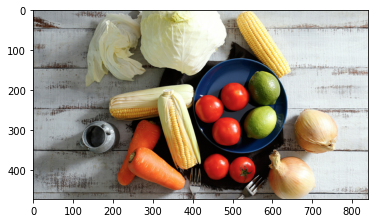

In [ ]:
### 用網址預測單張照片+預處理 ###
import requests
url = "https://www.fe-amart.com.tw/images/amart/photo/video/180604fruit/fruit.jpg"#@param {type:"string"}

response = requests.get(url, stream=True)
img = Image.open(response.raw).convert("RGB")

plt.imshow(img)

result_1, pre = predict_origin(img)
print("原圖預測： ",result_1)

print("===============分隔線=================")
result_2 = predict_dynamic_cut(img, 3)
print("看起來像是有這些： ", result_2)
# for p, val in zip(pre[0], trans):
#     print(val, "的機率:", round(p, 3))


In [ ]:
for p, val in zip(pre[0], trans):
    print(val, "的機率:", round(p, 3))

空心菜 的機率: 0.235
小白菜 的機率: 0.0
青江菜 的機率: 0.0
豆芽菜 的機率: 0.0
地瓜葉 的機率: 0.002
花椰菜 的機率: 0.0
芥藍菜 的機率: 0.0
大白菜 的機率: 0.0
高麗菜 的機率: 0.002
長年菜 的機率: 0.0
金針菇 的機率: 0.512
杏鮑菇 的機率: 0.004
香菇 的機率: 0.003
乾香菇 的機率: 0.0
綜合菇類 的機率: 0.01
豬五花 的機率: 0.0
豬肉片 的機率: 0.0
豬絞肉 的機率: 0.0
牛肉 的機率: 0.0
羊肉 的機率: 0.0
奶油 的機率: 0.001
雞肉 的機率: 0.001
魚肉 的機率: 0.004
雞胸肉 的機率: 0.0
鮭魚 的機率: 0.003
紅蘿蔔 的機率: 0.036
白蘿蔔 的機率: 0.049
馬鈴薯 的機率: 0.0
地瓜 的機率: 0.008
青椒 的機率: 0.001
甜椒 的機率: 0.0
雞蛋 的機率: 0.0
番茄 的機率: 0.0
蝦子 的機率: 0.002
洋蔥 的機率: 0.001
蘋果 的機率: 0.0
蔥 的機率: 0.071
薑 的機率: 0.0
猴頭菇 的機率: 0.0
玉米 的機率: 0.001
豆腐 的機率: 0.001
板豆腐 的機率: 0.0
豆干 的機率: 0.001
鳳梨 的機率: 0.001
韭菜 的機率: 0.008
這不是食材 的機率: 0.0
蛤蠣 的機率: 0.0
小黃瓜 的機率: 0.0
胡瓜 的機率: 0.001
櫛瓜 的機率: 0.0
茄子 的機率: 0.0
絲瓜 的機率: 0.0
南瓜 的機率: 0.0
橘子 的機率: 0.0
香蕉 的機率: 0.0
奇異果 的機率: 0.002
白飯 的機率: 0.0
雞翅 的機率: 0.0
雞腿 的機率: 0.0
苦瓜 的機率: 0.001
福山萵苣_又名大陸妹 的機率: 0.0
皮蛋 的機率: 0.0
豆皮 的機率: 0.0
茼蒿 的機率: 0.0
小松菜 的機率: 0.038


## 參考資料

### Transfer learning using Keras with DenseNet-169

https://medium.com/@carlosz22/transfer-learning-using-keras-with-densenet-169-91679300f94a

https://github.com/Elwing-Chou/tibaml1027/blob/main/transfer_learning.ipynb

https://www.kaggle.com/mpalermo/keras-pipeline-custom-generator-imgaug
